In [3]:
from environment import *
import numpy as np

Control using monte carlo:

### Variables

**__Value Function__** <br>
__Q__ ==> Keeps track of value of each state/action pair, it is a Matrix of size 10x21x2 <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;10 -- No. of possible states of dealer. (one card is face up)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;21 -- No. of possible states of player <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;2  -- No. of possible actions <br>

*__Step Size__* 

$\alpha = \frac{1}{N(s,a)}$ <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;N(s,a)   ==> Number of times 'a' was taken when in state 's'.  <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;|N(s,a)| ==> 10x21x2  <br>

$\epsilon = \frac{N_0}{N_0 - N(s_t)}$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$N_0$     ==> Constant value ~100 <br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;N($s_t$)  ==> Number of times state $s_t$ has been visited.

### *Action Function*

__Parameters__: state 

Chooses action based on Epsilon value:
With $\epsilon$ probability it takes a random action i.e hit or stick (prob of picking either action randomly is 0.5. <br>
With 1-$\epsilon$ probability we pick action greedily i.e action corresponding to max Q value. <br>


### *Training Agent*

__Parameters__: iterations

Initialize start state.

For each episode :<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Keep track of state,action pair, reward and number of times s,a pair were visited.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; For each state action pair update Q table. <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $error = r - Q_prev $<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $Q =: Q + error*stepsize$ <br>
                


In [47]:

class MC_Agent:
    def __init__(self, environment, n0):
        self.n0 = float(n0)
        self.env = environment
        
        # N(s) is the number of times that state s has been visited
        # N(s,a) is the number of times that action a has been selected from state s.
        self.N = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        
        self.Q = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        # self.E = np.zeros((self.env.dealer_values_count,
        #                    self.env.player_values_count, 
        #                    self.env.actions_count))

        # Initialise the value function to zero. 
        self.V = np.zeros((self.env.dealer_values_count, self.env.player_values_count))
        
        self.count_wins = 0
        self.iterations = 0

#     def get_action(self, s):
#         a = Actions.hit
#         return a
    
        # get optimal action, with epsilon exploration (epsilon dependent on number of visits to the state)
    # ε-greedy exploration strategy with εt = N0/(N0 + N(st)), 
    def get_action(self, state):
        dealer_idx = state.dealer-1
        player_idx = state.player-1
        n_visits = sum(self.N[dealer_idx, player_idx, :])

        # epsilon = N0/(N0 + N(st)
        curr_epsilon = self.n0 / (self.n0 + n_visits)

        # epsilon greedy policy
        if random.random() < curr_epsilon:
            r_action = Actions.hit if random.random()<0.5 else Actions.stick
#             if (dealer_idx == 0 and player_idx == 0):
#                 print ("epsilon:%s, random:%s " % (curr_epsilon, r_action))
            return r_action
        else:
            action = Actions.to_action(np.argmax(self.Q[dealer_idx, player_idx, :]))
#             if (dealer_idx == 0 and player_idx == 0):
#                 print ("epsilon:%s Qvals:%s Q:%s" % (curr_epsilon, self.Q[dealer_idx, player_idx, :], action))
            return action

    def train(self, iterations):        
        
        # Loop episodes
        for episode in xrange(iterations):
            episode_pairs = []
            
            # get initial state for current episode
            s = self.env.get_start_state()
            
            # Execute until game ends
            while not s.term:
                
                # get action with epsilon greedy policy
                a = self.get_action(s)
                
                # store action state pairs
                episode_pairs.append((s, a))
                
                # update visits
                # N(s) is the number of times that state s has been visited
                # N(s,a) is the number of times that action a has been selected from state s. 
                self.N[s.dealer-1, s.player-1, Actions.as_int(a)] += 1
                
                # execute action
                s,r = self.env.step(s, a)

            #if episode%10000==0: print "Episode: %d, Reward: %d" %(episode, my_state.rew)
            self.count_wins = self.count_wins+1 if r==1 else self.count_wins

            # Update Action value function accordingly
            for curr_s, curr_a in episode_pairs:
                # print s.dealer, s.player, s.r, a
                dealer_idx = curr_s.dealer-1
                player_idx = curr_s.player-1
                action_idx = Actions.as_int(curr_a)
                
                # Use a time-varying scalar step-size of αt = 1/N(st,at) 
#                 step = 1.0 / sum(self.N[dealer_idx, player_idx, :])
                step = 1.0 / self.N[dealer_idx, player_idx, action_idx]
                error = r - self.Q[dealer_idx, player_idx, action_idx]
                self.Q[dealer_idx, player_idx, action_idx] += step * error

        self.iterations += iterations
        print float(self.count_wins)/self.iterations*100

        # Derive value function
        for d in xrange(self.env.dealer_values_count):
            for p in xrange(self.env.player_values_count):
                self.V[d,p] = max(self.Q[d, p, :])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_values_count, 1)
        Y = np.arange(0, self.env.player_values_count, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf


SyntaxError: invalid syntax (<ipython-input-47-f2c5b5cdf77c>, line 94)

In [43]:
class MC_Agent:
    def __init__(self,environment,n0):
        self.n0 = float(n0)
        self.env = environment
        self.N = np.zeros((self.env.dealer_values_count, self.env.player_values_count, self.env.actions_count))
        self.Q = np.zeros((self.env.dealer_values_count, self.env.player_values_count, self.env.actions_count))
        self.V = np.zeros((self.env.dealer_values_count, self.env.player_values_count))
         
       
        
        self.count_wins = 0
        self.iterations = 0
        
    def get_action(self,state):
        dealer_idx = state.dealer - 1
        player_idx = state.player - 1
        
        n_visits = sum(self.N[dealer_idx, player_idx,:])
        epsilon = self.n0/(self.n0 + n_visits)
        
        if random.random() < epsilon:
            action = Actions.hit if random.random()<0.5 else Actions.stick
            return action
        else:
            action = Actions.to_action(np.argmax(self.Q[dealer_idx,player_idx,:]))

            return action
    
    def train(self, iterations):
        
          
        for epsiode in range(iterations):
            episode_pairs = []  
            s = self.env.get_start_state()
            while not s.term:
                a = self.get_action(s)
                episode_pairs.append((s,a))
                self.N[s.dealer-1,s.player-1,Actions.as_int(a)] += 1
                
                s,r = self.env.step(s, a)
                self.count_wins = self.count_wins+1 if r==1 else self.count_wins
            for curr_s,curr_a in episode_pairs:
                dealer_idx = curr_s.dealer - 1
                player_idx = curr_s.player - 1
                action_idx = Actions.as_int(curr_a)
                
                step    =  1/self.N[dealer_idx, player_idx, action_idx]
                error   =  r - self.Q[dealer_idx, player_idx, action_idx]
                self.Q +=  step*error
                
        self.iterations += iterations
        print (float(self.count_wins)/self.iterations*100)

        # Derive value function
        for d in range(self.env.dealer_values_count):
            for p in range(self.env.player_values_count):
                self.V[d,p] = max(self.Q[d, p, :])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_values_count, 1)
        Y = np.arange(0, self.env.player_values_count, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf
                
        

In [44]:
n0 = 100
agent = MC_Agent(Environment(), n0)
for i in range (10):
    agent.train(50)

30.0
36.0
36.666666666666664
37.0
36.4
38.0
39.714285714285715
39.75
40.22222222222222
40.6


In [51]:
def animate(frame):
    i = agent.iterations
    step_size = i
    step_size = max(1, step_size)
    step_size = min(step_size, 2 ** 16)
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('MC score:%s frame:%s step_size:%s ' % (float(agent.count_wins)/agent.iterations*100, frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    print (("done "), frame, step_size, i)
    return surf

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


100.0
done  0 1 0
50.0
done  0 1 1
25.0
done  1 2 2
37.5
done  2 4 4
43.75
done  3 8 8
46.875
done  4 16 16
50.0
done  5 32 32
52.34375
done  6 64 64
50.390625
done  7 128 128
44.53125
done  8 256 256
42.08984375
done  9 512 512
43.310546875
done  10 1024 1024
40.6494140625
done  11 2048 2048
39.19677734375
done  12 4096 4096
35.3515625
done  13 8192 8192
29.0283203125
done  14 16384 16384
21.2188720703125
done  15 32768 32768
14.12200927734375
done  16 65536 65536
10.789998372395832
done  17 65536 131072
8.805465698242188
done  18 65536 196608
7.489013671875
done  19 65536 262144
6.53533935546875
done  20 65536 327680
5.827113560267857
done  21 65536 393216
5.257415771484375
done  22 65536 458752
4.801601833767362
done  23 65536 524288
4.420166015625
done  24 65536 589824


KeyboardInterrupt: 

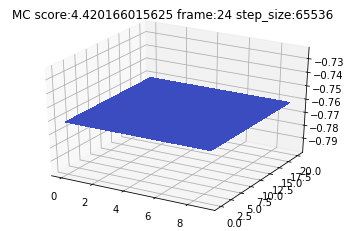

In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 100
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent.gif', writer='imagemagick', fps=3)
# plt.show()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


0.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
37.5
done  2 4 4
50.0
done  3 8 8
56.25
done  4 16 16
53.125
done  5 32 32
48.4375
done  6 64 64
46.875
done  7 128 128
42.7734375
done  8 256 256
42.67578125
done  9 512 512
44.62890625
done  10 1024 1024
44.7021484375
done  11 2048 2048
43.84765625
done  12 4096 4096
44.43359375
done  13 8192 8192
44.61669921875
done  14 16384 16384
44.53125
done  15 32768 32768
44.49920654296875
done  16 65536 65536
44.54345703125
done  17 65536 131072
44.643402099609375
done  18 65536 196608
44.62432861328125
done  19 65536 262144
44.672393798828125
done  20 65536 327680
44.65114048549107
done  21 65536 393216
44.62242126464844
done  22 65536 458752
44.64077419704861
done  23 65536 524288
44.63623046875
done  24 65536 589824
44.60990212180398
done  25 65536 655360
44.63564554850261
done  26 65536 720896
44.62961050180289
done  27 65536 786432
44.62225777762277
done  28 65536 851968
44.619649251302086
done  29 65536 917504
44.61565017700195
done  30 

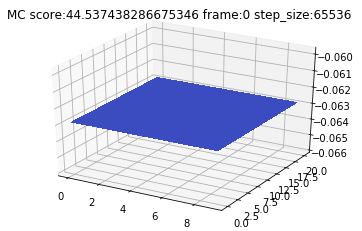

In [53]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 1000000
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N1000000")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 50, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent_N1000000.gif', writer='imagemagick', fps=3)